In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 학습, 검증, 테스트 데이터 로드
train_df = pd.read_csv('train.hate.csv')  # 학습 데이터 로드
dev_df = pd.read_csv('dev.hate.csv')      # 검증 데이터 로드
test_df = pd.read_csv('test.hate.no_label.csv')    # 테스트 데이터 로드

In [ ]:
# 라벨링 변환 (예: 'no' -> 0, 'offensive' -> 1, 'hate' -> 2)
label_mapping = {'no': 0, 'offensive': 1, 'hate': 2}
train_df['label'] = train_df['label'].map(label_mapping)
dev_df['label'] = dev_df['label'].map(label_mapping)

# 결측치 확인 및 제거
train_df = train_df.dropna(subset=['label', 'comments'])
dev_df = dev_df.dropna(subset=['label', 'comments'])

# 데이터셋 확인
if train_df.empty:
    raise ValueError("학습 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")
if dev_df.empty:
    raise ValueError("검증 데이터셋이 비어 있습니다. 데이터 파일의 내용을 확인하세요.")

In [ ]:
from transformers import ElectraForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch

# KcELECTRA 모델과 토크나이저 로드
model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

def encode_data(data):
    # 텍스트 토큰화 및 변환
    encodings = tokenizer(
        data['comments'].tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # max_length를 지정하여 입력 길이 제한
    )
    return encodings

# 학습 및 검증 데이터 토큰화
train_encodings = encode_data(train_df)
val_encodings = encode_data(dev_df)

# 라벨을 텐서로 변환
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(dev_df['label'].values)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# 데이터셋 생성
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# 하이퍼파라미터 후보 설정
epochs_list = [3, 4, 5]
batch_size_list = [8, 16, 32]
learning_rate_list = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5]

best_f1 = 0
best_params = {}

for epochs in tqdm(epochs_list, desc="Epochs"):
    for batch_size in tqdm(batch_size_list, desc="Batch Size", leave=False):
        for learning_rate in tqdm(learning_rate_list, desc="Learning Rate", leave=False):
            training_args = TrainingArguments(
                output_dir='./results',
                num_train_epochs=epochs,
                per_device_train_batch_size=batch_size,
                learning_rate=learning_rate,
                per_device_eval_batch_size=16,
                warmup_steps=500,
                weight_decay=0.01,
                eval_strategy="epoch",
                save_strategy="epoch",
                logging_dir='./logs',
                logging_steps=10,
                report_to="none",
                save_total_limit=1,
                load_best_model_at_end=True
            )

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=lambda p: {
                    'f1': f1_score(p.label_ids, torch.argmax(torch.tensor(p.predictions), axis=1), average='weighted')
                }
            )

            trainer.train()
            eval_results = trainer.evaluate()
            f1 = eval_results['eval_f1']

            if f1 > best_f1:
                best_f1 = f1
                best_params = {
                    'num_train_epochs': epochs,
                    'per_device_train_batch_size': batch_size,
                    'learning_rate': learning_rate
                }

print("Best F1 Score:", best_f1)
print("Best Parameters:", best_params)

Batch Size:   0%|          | 0/3 [00:00<?, ?it/s]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.837200,0.817063,0.576565
2,0.625200,0.734993,0.664228
3,0.451200,0.790362,0.671828




Learning Rate:  20%|██        | 1/5 [02:32<10:10, 152.51s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.487700,1.096464,0.628287
2,0.381800,1.347161,0.632908
3,0.203900,1.472111,0.665754




Learning Rate:  40%|████      | 2/5 [05:02<07:32, 150.83s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.469400,1.407868,0.664630
2,0.599800,1.192153,0.697431
3,0.111700,1.502224,0.692589




Learning Rate:  60%|██████    | 3/5 [07:32<05:00, 150.50s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.282100,2.052282,0.610687
2,0.239900,1.721245,0.691750
3,0.143700,1.839745,0.689137




Learning Rate:  80%|████████  | 4/5 [10:01<02:30, 150.02s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.159500,2.438395,0.606941
2,0.327700,1.967077,0.668942
3,0.068300,1.950781,0.692791




Learning Rate: 100%|██████████| 5/5 [12:31<00:00, 149.82s/it]

                                                             
Batch Size:  33%|███▎      | 1/3 [12:31<25:02, 751.03s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.019800,2.062454,0.694948
2,0.077400,1.967350,0.691921
3,0.085200,2.115173,0.687755




Learning Rate:  20%|██        | 1/5 [01:44<06:56, 104.06s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.047000,2.588865,0.673958
2,0.000700,2.509151,0.666332
3,0.105200,2.503577,0.677278




Learning Rate:  40%|████      | 2/5 [03:31<05:18, 106.17s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.077500,2.644080,0.680054
2,0.048100,2.287004,0.688810
3,0.117300,2.495346,0.683825




Learning Rate:  60%|██████    | 3/5 [05:16<03:30, 105.46s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.058100,2.160029,0.682980
2,0.001700,2.390419,0.674120
3,0.133600,2.469534,0.696143




Learning Rate:  80%|████████  | 4/5 [07:03<01:46, 106.31s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.142900,2.451729,0.674033
2,0.101600,2.192044,0.663361
3,0.104100,2.447596,0.684292




Learning Rate: 100%|██████████| 5/5 [08:48<00:00, 105.73s/it]

                                                             
Batch Size:  67%|██████▋   | 2/3 [21:19<10:20, 620.21s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.033700,2.195828,0.669597
2,0.013900,2.367674,0.669066
3,0.035000,2.446074,0.678428




Learning Rate:  20%|██        | 1/5 [01:28<05:52, 88.17s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.010300,2.469997,0.669135
2,0.026900,2.547831,0.663498
3,0.056000,2.596370,0.659676




Learning Rate:  40%|████      | 2/5 [03:00<04:32, 90.81s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,2.756440,0.673202
2,0.072800,2.307807,0.677997
3,0.025600,2.355848,0.680834




Learning Rate:  60%|██████    | 3/5 [04:33<03:02, 91.49s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.002700,2.807923,0.659694
2,0.063900,2.250592,0.656906
3,0.047400,2.013777,0.682018




Learning Rate:  80%|████████  | 4/5 [06:01<01:30, 90.34s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000400,2.486718,0.689267
2,0.020600,2.480877,0.660770
3,0.050000,2.461479,0.680223




Learning Rate: 100%|██████████| 5/5 [07:31<00:00, 90.28s/it]

                                                            
Batch Size:   0%|          | 0/3 [00:00<?, ?it/s]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.305622,0.642261
2,0.000000,3.616961,0.633032
3,0.000000,3.283542,0.653239
4,0.001100,3.207569,0.669037




Learning Rate:  20%|██        | 1/5 [03:18<13:12, 198.05s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.049400,4.007407,0.593849
2,0.000000,3.235443,0.661670
3,0.031700,3.474805,0.649666
4,0.168100,3.474671,0.652334




Learning Rate:  40%|████      | 2/5 [06:32<09:47, 195.94s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.374993,0.644817
2,0.000200,3.847249,0.615090
3,0.000100,3.298830,0.632925
4,0.000100,3.133470,0.651908




Learning Rate:  60%|██████    | 3/5 [09:47<06:31, 195.73s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.023700,2.452004,0.672423
2,0.000700,2.466423,0.677146
3,0.000200,2.958655,0.657738
4,0.000100,3.032259,0.666530




Learning Rate:  80%|████████  | 4/5 [13:03<03:15, 195.76s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,3.155474,0.681597
2,0.037600,2.643602,0.682554
3,0.094600,2.842103,0.639794
4,0.000100,3.065945,0.646835




Learning Rate: 100%|██████████| 5/5 [16:18<00:00, 195.22s/it]

                                                             
Batch Size:  33%|███▎      | 1/3 [16:18<32:36, 978.07s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.000700,2.984901,0.634351
2,0.000100,2.943625,0.659474
3,0.007700,2.989661,0.680106
4,0.025500,3.021877,0.684818




Learning Rate:  20%|██        | 1/5 [02:16<09:07, 136.84s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.349332,0.661249
2,0.000000,3.094437,0.684794
3,0.008200,3.319804,0.662198
4,0.000100,3.228359,0.657821




Learning Rate:  40%|████      | 2/5 [04:33<06:50, 136.95s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.796706,0.614495
2,0.047700,3.089595,0.662018
3,0.006500,3.105590,0.648680
4,0.000200,3.047075,0.658357




Learning Rate:  60%|██████    | 3/5 [06:50<04:33, 136.90s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.033700,3.834813,0.643199
2,0.000200,2.723179,0.673944
3,0.105600,2.947535,0.672000
4,0.091000,3.020668,0.677234




Learning Rate:  80%|████████  | 4/5 [09:11<02:18, 138.62s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.065800,3.141937,0.635953
2,0.000200,2.942179,0.667433
3,0.034900,2.729416,0.660438
4,0.034000,3.048611,0.640085




Learning Rate: 100%|██████████| 5/5 [11:29<00:00, 138.36s/it]

                                                             
Batch Size:  67%|██████▋   | 2/3 [27:47<13:28, 808.55s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.000300,2.938949,0.643573
2,0.000200,2.867414,0.659223
3,0.032100,3.077481,0.644054
4,0.000100,3.101851,0.642503




Learning Rate:  20%|██        | 1/5 [02:00<08:03, 120.83s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,3.146559,0.651059
2,0.000000,3.333187,0.655870
3,0.004000,2.927213,0.641417
4,0.000200,2.907382,0.666291




Learning Rate:  40%|████      | 2/5 [04:00<05:59, 119.95s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.191371,0.649409
2,0.000000,3.572836,0.637120
3,0.001000,3.888562,0.634372
4,0.000100,2.965118,0.657432




Learning Rate:  60%|██████    | 3/5 [06:00<03:59, 119.90s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.286680,0.664841
2,0.012200,2.732878,0.686916
3,0.000900,2.966198,0.649488
4,0.006700,3.064981,0.660137




Learning Rate:  80%|████████  | 4/5 [08:00<01:59, 119.98s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.001900,3.456512,0.624810
2,0.011500,3.121552,0.662043
3,0.026500,3.043044,0.637063
4,0.000100,2.982789,0.670087




Learning Rate: 100%|██████████| 5/5 [09:59<00:00, 119.89s/it]

                                                             
Batch Size:   0%|          | 0/3 [00:00<?, ?it/s]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.540059,0.612044
2,0.000000,3.711017,0.643794
3,0.009300,3.900707,0.624264
4,0.000000,3.793094,0.643198
5,0.020600,3.712924,0.654227




Learning Rate:  20%|██        | 1/5 [04:01<16:06, 241.62s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000300,4.148813,0.622005
2,0.114000,3.768699,0.668620
3,0.000000,3.861369,0.635559
4,0.000100,3.882693,0.664272
5,0.026100,4.117052,0.638452




Learning Rate:  40%|████      | 2/5 [08:10<12:18, 246.18s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.583303,0.658520
2,0.000000,3.798112,0.651549
3,0.074000,3.923934,0.623434
4,0.066400,3.456543,0.643982
5,0.014300,3.560006,0.643003




Learning Rate:  60%|██████    | 3/5 [12:25<08:19, 250.00s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,3.851786,0.640958
2,0.000100,3.263399,0.651928
3,0.050500,3.485693,0.636109
4,0.000000,3.705064,0.642046
5,0.000100,3.814407,0.614765




Learning Rate:  80%|████████  | 4/5 [16:40<04:11, 251.82s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.002800,3.891656,0.577058
2,0.130100,2.743902,0.685049
3,0.001100,3.018152,0.661428
4,0.212800,3.212309,0.641388
5,0.000100,3.186098,0.654067




Learning Rate: 100%|██████████| 5/5 [20:53<00:00, 252.23s/it]

                                                             
Batch Size:  33%|███▎      | 1/3 [20:53<41:46, 1253.12s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.010600,3.115761,0.656618
2,0.000100,3.334675,0.659509
3,0.000100,3.236456,0.636072
4,0.067300,3.140922,0.645709
5,0.007000,3.179821,0.640960




Learning Rate:  20%|██        | 1/5 [02:51<11:25, 171.26s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.008600,3.444413,0.646467
2,0.044100,3.336258,0.644855
3,0.000100,3.113914,0.645064
4,0.056000,3.192958,0.649157
5,0.067300,3.341151,0.637135




Learning Rate:  40%|████      | 2/5 [05:42<08:34, 171.43s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.006000,4.135196,0.635383
2,0.000000,4.324019,0.645312
3,0.000100,3.374455,0.655572
4,0.000100,3.606351,0.633356
5,0.007000,3.560548,0.641549




Learning Rate:  60%|██████    | 3/5 [08:38<05:46, 173.24s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.009900,3.479043,0.655292
2,0.000000,3.536647,0.661207
3,0.000100,3.444587,0.652191
4,0.000100,3.474906,0.637010
5,0.020500,3.607565,0.626111




Learning Rate:  80%|████████  | 4/5 [11:29<02:52, 172.58s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,4.076972,0.652312
2,0.001100,2.900113,0.649270
3,0.000300,3.380088,0.609968
4,0.000200,3.343705,0.642247
5,0.000300,3.394481,0.641454




Learning Rate: 100%|██████████| 5/5 [14:21<00:00, 172.20s/it]

                                                             
Batch Size:  67%|██████▋   | 2/3 [35:14<17:02, 1022.64s/it]

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,3.109638,0.628678
2,0.031000,3.150044,0.627499
3,0.018400,3.274703,0.627534
4,0.005800,3.213563,0.638468
5,0.000300,3.179590,0.642996




Learning Rate:  20%|██        | 1/5 [02:25<09:42, 145.71s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000100,3.441311,0.626244
2,0.021900,3.299041,0.621583
3,0.023400,3.352844,0.628431
4,0.000100,3.193845,0.646735
5,0.000100,3.244803,0.652205




Learning Rate:  40%|████      | 2/5 [04:51<07:17, 145.67s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,3.712747,0.644323
2,0.000000,4.267713,0.610725
3,0.000000,4.240318,0.638875
4,0.000200,3.739361,0.643630
5,0.000400,3.504938,0.645713




Learning Rate:  60%|██████    | 3/5 [07:16<04:51, 145.59s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.000000,4.107701,0.648653
2,0.014500,4.520884,0.570116
3,0.021700,3.826084,0.602596
4,0.000000,3.907321,0.644340
5,0.000000,3.917294,0.639327




Learning Rate:  80%|████████  | 4/5 [09:41<02:25, 145.02s/it]

Epoch,Training Loss,Validation Loss,F1
1,0.007100,4.159731,0.603889
2,0.000000,4.094404,0.613825
3,0.014000,3.047004,0.643545
4,0.000100,3.337941,0.625634
5,0.000100,3.376863,0.626131




Learning Rate: 100%|██████████| 5/5 [12:07<00:00, 145.54s/it]

                                                             
Epochs: 100%|██████████| 3/3 [1:54:01<00:00, 2280.44s/it]

Best F1 Score: 0.6974311653030627
Best Parameters: {'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'learning_rate': 3e-05}


In [ ]:
# best_params = {
#     'num_train_epochs': 3,
#     'per_device_train_batch_size': 16,
#     'learning_rate': 5e-5
# }

best_params = {
    'num_train_epochs': 3,
    'per_device_train_batch_size': 8,
    'learning_rate': 3e-5
}

training_args = TrainingArguments(
    output_dir='./best_results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    learning_rate=best_params['learning_rate'],
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./best_logs',
    logging_steps=10,
    report_to="none",
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.000000,4.699371
2,0.000100,4.522780
3,0.014100,4.273644


TrainOutput(global_step=2961, training_loss=0.012576140591685254, metrics={'train_runtime': 147.2355, 'train_samples_per_second': 160.885, 'train_steps_per_second': 20.111, 'total_flos': 900809897063328.0, 'train_loss': 0.012576140591685254, 'epoch': 3.0})

      Metric     Score
0   Accuracy  0.624204
1  Precision  0.627680
2     Recall  0.624204
3   F1 Score  0.610923


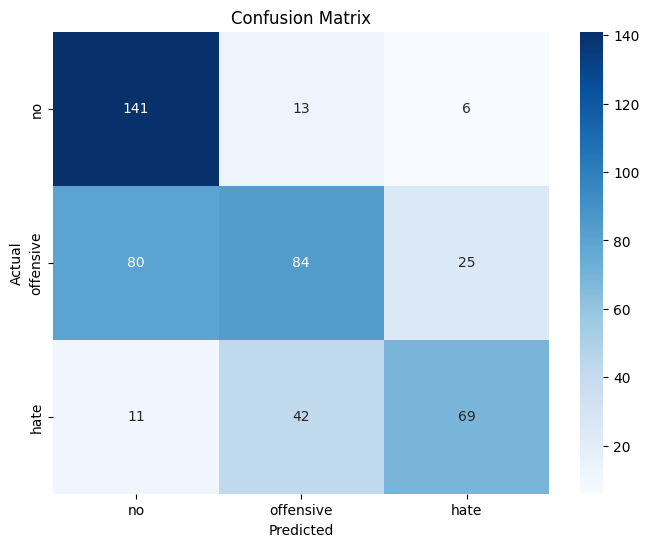

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# 평가를 위한 예측 및 지표 계산
predictions = trainer.predict(val_dataset)
y_preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
y_true = val_labels.numpy()

# 평가 지표 계산
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds, average='weighted')
recall = recall_score(y_true, y_preds, average='weighted')
f1 = f1_score(y_true, y_preds, average='weighted')

# 결과를 표로 정리
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})
print(metrics_df)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'offensive', 'hate'], yticklabels=['no', 'offensive', 'hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 테스트 데이터 예측 및 CSV 저장
from sklearn.metrics import classification_report, confusion_matrix

# 테스트 데이터 예측
test_encodings = encode_data(test_df)
test_dataset = CustomDataset(test_encodings)
test_predictions = trainer.predict(test_dataset)
test_preds = torch.argmax(torch.tensor(test_predictions.predictions), axis=1)

# 예측 결과를 데이터프레임에 저장
output_df = test_df.copy()
output_df['label'] = test_preds.numpy()

# CSV 파일로 저장
output_df.to_csv('test.hate.predicted_KcELECTRA_v7.csv', index=False)
print("테스트 데이터의 예측 결과가 test.hate.predicted.csv 파일에 저장되었습니다.")

테스트 데이터의 예측 결과가 test.hate.predicted.csv 파일에 저장되었습니다.
